In [123]:
# Run this code to unzip the Skin Diseases Data into a "dataset" folder
import zipfile as zf
files = zf.ZipFile("archive.zip", 'r')
files.extractall('dataset')
files.close()

In [1]:
# Useful Imports
import torch 
import torch.nn as nn
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

In [2]:
# Converts every image to 256x256 dimension and into a Tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Loads each subset directory from your "dataset" folder
train_dataset = datasets.ImageFolder(root='dataset/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='dataset/Test', transform=transform)
val_dataset = datasets.ImageFolder(root='dataset/Val', transform=transform)

# Hyper Parameters for dataset organization and processing
batch_size = 50
num_workers = 3

# Dataloader for each subset which will batch, shuffle, and parallel load the data
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [3]:
# Total images in each subset
print('Train data: ', len(train_dataset))
print('Test data: ', len(test_dataset))
print('Valid data: ', len(val_dataset))

Train data:  1198
Test data:  389
Valid data:  250


torch.Size([3, 256, 256])
tensor(2)


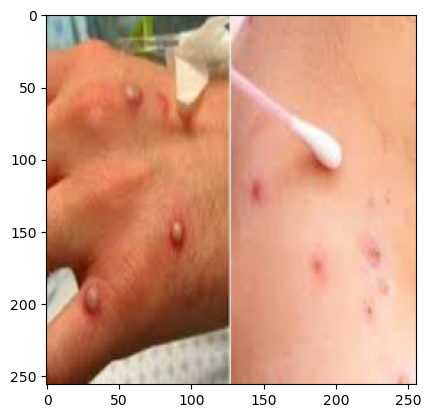

In [4]:
# Check a batch of data
images, labels = next(iter(train_dataloader))

print(images[0].size()) # Number of Colors (RGB=3), Height=256, Width=256
print(labels[0]) # Herpes=0, Melanoma=1, Monkeypox=2, Sarampion=3, Varicela=4

# Will the image sampled
image = transforms.ToPILImage()(images[0])
plt.imshow(image)
plt.show()

In [5]:
# Calculates output layer size, convenient when making multiple hidden layers
image_size = 61
kernel_size = 3
padding = 0
stride = 1
pool = 3

output_shape = np.floor((((image_size - kernel_size + (2 * padding)) / stride) + 1) / pool)
print(output_shape)

19.0


In [6]:
# Custom CNN Model

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0), #(64, 254, 254)
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #(128, 126, 126)

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #(128, 61, 61)

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3)) #(64, 19, 19)
        
        self.fc1 = nn.Sequential(
            nn.Linear(64*19*19, 64),
            nn.ReLU())
        
        self.fc2 = nn.Linear(64, 5)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.view(-1, 64*19*19)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [7]:
# Allows model to run on GPU if it is present
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Test run, should output torch.Size([batch_size, classes])
custom_cnn = CustomCNN().to(device)
output = custom_cnn(images.to(device))
print(output.size())

torch.Size([50, 5])


In [9]:
# Declare Model
custom_cnn = CustomCNN().to(device)

# Set Hyper Parameters
epochs = 5
learning_rate = 0.001

# Declare Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr = learning_rate)

In [10]:
# Train the model
total_step = len(train_dataloader)
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = custom_cnn(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [1/24], Loss: 1.6221
Epoch [1/5], Step [2/24], Loss: 1.8307
Epoch [1/5], Step [3/24], Loss: 1.6154
Epoch [1/5], Step [4/24], Loss: 1.6131
Epoch [1/5], Step [5/24], Loss: 1.5850
Epoch [1/5], Step [6/24], Loss: 1.6448
Epoch [1/5], Step [7/24], Loss: 1.6006
Epoch [1/5], Step [8/24], Loss: 1.6634
Epoch [1/5], Step [9/24], Loss: 1.6151
Epoch [1/5], Step [10/24], Loss: 1.6031
Epoch [1/5], Step [11/24], Loss: 1.6200
Epoch [1/5], Step [12/24], Loss: 1.5998
Epoch [1/5], Step [13/24], Loss: 1.6057
Epoch [1/5], Step [14/24], Loss: 1.6123
Epoch [1/5], Step [15/24], Loss: 1.6120
Epoch [1/5], Step [16/24], Loss: 1.5783
Epoch [1/5], Step [17/24], Loss: 1.5775
Epoch [1/5], Step [18/24], Loss: 1.5686
Epoch [1/5], Step [19/24], Loss: 1.5496
Epoch [1/5], Step [20/24], Loss: 1.5387
Epoch [1/5], Step [21/24], Loss: 1.5514
Epoch [1/5], Step [22/24], Loss: 1.4954
Epoch [1/5], Step [23/24], Loss: 1.4542
Epoch [1/5], Step [24/24], Loss: 1.3582
Epoch [2/5], Step [1/24], Loss: 1.4290
Epoch [2/5

In [11]:
# Define a calculate_accuracy function
def calculate_accuracy(model, dataloader, device):
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')

In [12]:
# Calculate validation accuracy of model
calculate_accuracy(custom_cnn, val_dataloader, device)

Accuracy: 48.4%


In [13]:
# Produces a confusion matrix, and metrics including Precision, Recall, and F1 Score
def confusion_matrix_and_metrics(model, dataloader, device):
    model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap="Blues", 
        xticklabels=dataloader.dataset.classes, 
        yticklabels=dataloader.dataset.classes)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Precision of the MLP :\t"+str(precision_score(y_true, y_pred, average="macro")))
    print("Recall of the MLP    :\t"+str(recall_score(y_true, y_pred, average="macro")))
    print("F1 Score of the Model :\t"+str(f1_score(y_true, y_pred, average="macro")))

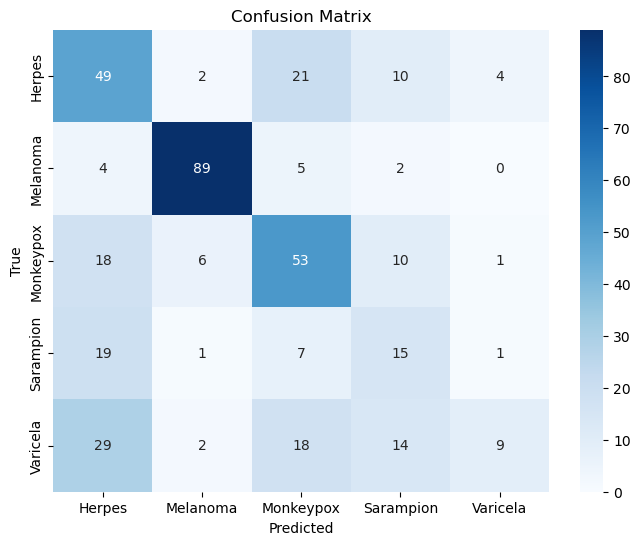

Precision of the MLP :	0.5410995475113122
Recall of the MLP    :	0.5071754756871036
F1 Score of the Model :	0.4892355203430978


In [14]:
# Test code for above function
confusion_matrix_and_metrics(custom_cnn, test_dataloader, device)